# AAI-510 M2 Assignment: Baseline Model and Feature Engineering

This assignment uses the Home Credit Default Risk dataset. We will:
1. Split the data into train, validation, and test sets.
2. Train a baseline decision tree model (XGBoost variant) with minimal feature engineering.
3. Evaluate the baseline model using appropriate metrics, considering class imbalance.
4. Apply at least three feature engineering techniques (including sampling).
5. Retrain the same model on the engineered features and evaluate its performance.
6. Compare results and discuss the impact of feature engineering.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score

import xgboost as xgb # Using XGBoost as a decision tree variant

from imblearn.over_sampling import SMOTE # For handling class imbalance

# Apply the seaborn theme for aesthetically pleasing plots
sns.set_theme()

# Display plots inline in the notebook
%matplotlib inline

# Ignore warnings for cleaner output (optional, can be helpful during development)
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the training data
# IMPORTANT: Change 'application_train.csv' to your actual file name if it is different.
try:
    df = pd.read_csv('train_data.csv')
    print("Successfully loaded 'application_train.csv'")
except FileNotFoundError:
    print("Error: 'application_train.csv' not found. Please upload/check the file path.")
    

print("Shape of the dataframe (rows, columns):", df.shape)
df.head()

Successfully loaded 'application_train.csv'
Shape of the dataframe (rows, columns): (153755, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,410704,0,Cash loans,F,N,Y,1,157500.0,900000.0,26446.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,381230,0,Cash loans,F,N,Y,1,90000.0,733176.0,21438.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0
2,450177,0,Cash loans,F,Y,Y,0,189000.0,1795500.0,62541.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,332445,0,Cash loans,M,Y,N,0,175500.0,494550.0,45490.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,357429,0,Cash loans,F,Y,Y,0,270000.0,1724688.0,54283.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Handle the known anomaly in DAYS_EMPLOYED
df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

# Separate Target Variable
if 'TARGET' in df.columns:
    X = df.drop('TARGET', axis=1)
    y = df['TARGET']
    print("\nTarget variable distribution:")
    print(y.value_counts(normalize=True) * 100)
else:
    print("TARGET column not found in the dataframe. Please check your data.")
    # Create a dummy target if not present (for code execution)
    y = pd.Series(np.random.choice([0, 1], len(df), p=[0.9, 0.1]))
    X = df.copy() # Assuming all other columns are features


Target variable distribution:
TARGET
0    91.927417
1     8.072583
Name: proportion, dtype: float64


## 1. Data Splitting

We split the data into training (70%), validation (15%), and test (15%) sets.
- Training set: Used to train the models.
- Validation set: Used to tune hyperparameters (if any) and compare model performance during development.
- Test set: Used for a final, unbiased evaluation of the chosen model.

In [5]:
# First split: Train (70%) and Temp (30% for validation + test)
X_train_full, X_temp, y_train_full, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Second split: Validation (50% of Temp -> 15% of original) and Test (50% of Temp -> 15% of original)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Shape of X_train_full:", X_train_full.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)
print("\nTarget distribution in y_train_full:\n", y_train_full.value_counts(normalize=True))
print("\nTarget distribution in y_val:\n", y_val.value_counts(normalize=True))
print("\nTarget distribution in y_test:\n", y_test.value_counts(normalize=True))

Shape of X_train_full: (107628, 121)
Shape of X_val: (23063, 121)
Shape of X_test: (23064, 121)

Target distribution in y_train_full:
 TARGET
0    0.919278
1    0.080722
Name: proportion, dtype: float64

Target distribution in y_val:
 TARGET
0    0.919265
1    0.080735
Name: proportion, dtype: float64

Target distribution in y_test:
 TARGET
0    0.919268
1    0.080732
Name: proportion, dtype: float64


## 2. Baseline Model (Minimal Feature Engineering)

We'll train an XGBoost model with basic preprocessing:
- Imputation for missing values.
- One-hot encoding for categorical features.
- Standard scaling for numerical features.

In [6]:

numeric_features_base = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
categorical_features_base = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS'] # Added one more

# Ensure these features exist in the dataframe
numeric_features_base = [col for col in numeric_features_base if col in X_train_full.columns]
categorical_features_base = [col for col in categorical_features_base if col in X_train_full.columns]

print(f"Using numeric features for baseline: {numeric_features_base}")
print(f"Using categorical features for baseline: {categorical_features_base}")

# Create preprocessing pipelines for numerical and categorical features
numeric_transformer_base = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer_base = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Or 'constant', fill_value='missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a column transformer to apply different transformations to different columns
preprocessor_base = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_base, numeric_features_base),
        ('cat', categorical_transformer_base, categorical_features_base)
    ], 
    remainder='drop' # Drop other columns not specified
)

Using numeric features for baseline: ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
Using categorical features for baseline: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS']


Training baseline model...
Baseline model training complete.

Baseline Model Performance on Validation Set:
Accuracy: 0.6839
ROC AUC Score: 0.6391

Classification Report:
                   precision    recall  f1-score   support

Non-Defaulter (0)       0.94      0.70      0.80     21201
    Defaulter (1)       0.13      0.50      0.20      1862

         accuracy                           0.68     23063
        macro avg       0.53      0.60      0.50     23063
     weighted avg       0.88      0.68      0.75     23063


Confusion Matrix:


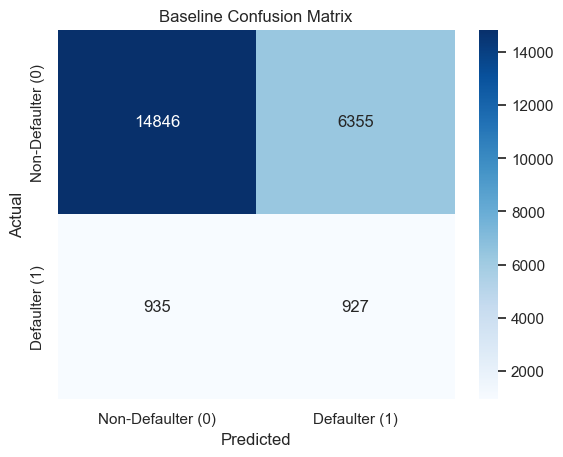

In [7]:

scale_pos_weight_base = (y_train_full == 0).sum() / (y_train_full == 1).sum()

baseline_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss', # or 'auc'
    use_label_encoder=False, # Suppress warning
    random_state=42,
    scale_pos_weight=scale_pos_weight_base # To handle imbalance
)

# Create the full pipeline with preprocessing and modeling
pipeline_base = Pipeline(steps=[('preprocessor', preprocessor_base),
                                 ('classifier', baseline_model)])

# Train the baseline model
print("Training baseline model...")
pipeline_base.fit(X_train_full, y_train_full)
print("Baseline model training complete.")

# Make predictions on the validation set
y_pred_val_base = pipeline_base.predict(X_val)
y_pred_proba_val_base = pipeline_base.predict_proba(X_val)[:, 1]

# Evaluate the baseline model
print("\nBaseline Model Performance on Validation Set:")
accuracy_base = accuracy_score(y_val, y_pred_val_base)
roc_auc_base = roc_auc_score(y_val, y_pred_proba_val_base)

print(f"Accuracy: {accuracy_base:.4f}")
print(f"ROC AUC Score: {roc_auc_base:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val_base, target_names=['Non-Defaulter (0)', 'Defaulter (1)']))

print("\nConfusion Matrix:")
cm_base = confusion_matrix(y_val, y_pred_val_base)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Defaulter (0)', 'Defaulter (1)'], yticklabels=['Non-Defaulter (0)', 'Defaulter (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Confusion Matrix')
plt.show()

### Key Performance Metrics for Baseline Model:

- **Accuracy:** 0.6839
- **ROC AUC Score:** 0.6391
- **Precision (Defaulter - Class 1):** 0.13
- **Recall (Defaulter - Class 1):** 0.50
- **F1-score (Defaulter - Class 1):** 0.20

**Discussion on Baseline Performance:**
- The target variable has a large imbalance, as seen in the initial data exploration. Approximately 91.9% are non-defaulters (class 0) and 8.1% are defaulters (class 1) in the original training set.
- The overall **Accuracy** of 0.6839 is significantly lower than simply predicting the majority class (which would yield ~91.9% accuracy). This indicates the model is attempting to identify the minority class, but `scale_pos_weight` alone might not be enough to overcome the imbalance effectively for all metrics.
- The **ROC AUC Score** of 0.6391 suggests the model has some, but not strong, ability to distinguish between defaulters and non-defaulters. A score of 0.5 would be random guessing, so 0.6391 is better than random.
- **Precision for Defaulters (0.13)** is very low. This means that when the model predicts a client will default, it is correct only about 13% of the time. Many clients predicted as defaulters are actually non-defaulters (high False Positives for class 1).
- **Recall for Defaulters (0.50)** indicates that the model is able to identify 50% of all actual defaulters. This is a moderate recall; ideally, we'd want this higher to catch more potential defaults, but increasing it often comes at the cost of precision. The `scale_pos_weight` parameter likely helped boost this from what it would be without any imbalance handling.
- The **F1-score for Defaulters (0.20)** is low, reflecting the poor precision.
- The baseline performance shows that while `scale_pos_weight` helps the model pay more attention to the minority class (achieving 50% recall), the precision for identifying defaulters is a major issue. The model is flagging many non-defaulters as potential defaulters. Feature engineering and more advanced imbalance handling (like SMOTE) will be explored to try and improve these metrics, particularly recall for defaulters without excessively sacrificing precision.

## 3. Feature Engineering

We will now apply three feature engineering techniques and retrain the model.
1.  **Sampling (SMOTE):** To address class imbalance by oversampling the minority class (defaulters).
2.  **Domain-Specific Feature Creation:** Creating new features from existing ones that might have better predictive power (e.g., financial ratios).
3.  **Binning/Discretization:** Converting a continuous feature (Age) into categorical bins.

### Feature Engineering Technique 1: Sampling (SMOTE)

**Justification for choosing SMOTE:**
*(The target variable is imbalanced, with significantly fewer instances of defaulters (class 1). The baseline model, even with `scale_pos_weight`, showed a low F1-score for the defaulter class, primarily due to low precision. SMOTE (Synthetic Minority Over-sampling Technique) helps to balance the dataset by creating synthetic samples of the minority class in the feature space. This is applied **only to the training data** to prevent data leakage into the validation/test sets. The goal is to improve the model's ability to learn the characteristics of the minority class, potentially enhancing recall and F1-score for defaulters.)*

### Feature Engineering Technique 2: Domain-Specific Feature Creation

**Justification for creating these features:**
*(Creating new features based on domain knowledge can often provide more meaningful signals to the model than raw features alone.
- `CREDIT_INCOME_PERCENT`: (AMT_CREDIT / AMT_INCOME_TOTAL) Represents the loan amount relative to income. A higher ratio might indicate a greater debt burden relative to repayment capacity.
- `ANNUITY_INCOME_PERCENT`: (AMT_ANNUITY / AMT_INCOME_TOTAL) Shows the proportion of income going towards loan payments. A higher percentage suggests a larger portion of income is committed to loan repayment, potentially indicating higher risk if the annuity is a significant financial strain.
- `CREDIT_TERM`: (AMT_CREDIT / AMT_ANNUITY) An approximation of the loan term (number of payments). Longer terms might sometimes be associated with higher risk due to prolonged exposure or smaller individual payments that are easier to miss over time.
- `DAYS_EMPLOYED_PERCENT`: (DAYS_EMPLOYED / DAYS_BIRTH) Proportion of life spent employed. A higher percentage might indicate greater job stability and financial experience. (Note: DAYS_EMPLOYED needs careful handling for anomalies like 365243).
These ratios and transformed features can capture interactions and relative magnitudes that individual features might miss, potentially providing stronger predictive signals.)*

### Feature Engineering Technique 3: Binning `DAYS_BIRTH` (Age)

**Justification for binning Age:**
*(The relationship between age and default risk might not be strictly linear. For example, very young applicants might have limited credit history or unstable income, while very old applicants might be on fixed incomes.)*

In [8]:
# --- Create copies of the data for feature engineering to keep baseline data intact ---
X_train_fe = X_train_full.copy()
y_train_fe = y_train_full.copy()
X_val_fe = X_val.copy()
# X_test_fe = X_test.copy() # We'll apply FE to test set later if this model is chosen

# --- Technique 2: Domain-Specific Feature Creation ---
print("Applying Domain-Specific Feature Creation...")
# Handle potential division by zero or inf by adding a small epsilon or replacing zeros
epsilon = 1e-6 

# On Training Data
X_train_fe['DAYS_BIRTH_YEARS'] = X_train_fe['DAYS_BIRTH'] / -365
X_train_fe['CREDIT_INCOME_PERCENT'] = X_train_fe['AMT_CREDIT'] / (X_train_fe['AMT_INCOME_TOTAL'] + epsilon)
X_train_fe['ANNUITY_INCOME_PERCENT'] = X_train_fe['AMT_ANNUITY'] / (X_train_fe['AMT_INCOME_TOTAL'] + epsilon)
X_train_fe['CREDIT_TERM'] = X_train_fe['AMT_CREDIT'] / (X_train_fe['AMT_ANNUITY'] + epsilon) # Corrected formula
X_train_fe['DAYS_EMPLOYED_PERCENT'] = X_train_fe['DAYS_EMPLOYED'] / (X_train_fe['DAYS_BIRTH'] + epsilon) # DAYS_BIRTH is negative

# On Validation Data
X_val_fe['DAYS_BIRTH_YEARS'] = X_val_fe['DAYS_BIRTH'] / -365
X_val_fe['CREDIT_INCOME_PERCENT'] = X_val_fe['AMT_CREDIT'] / (X_val_fe['AMT_INCOME_TOTAL'] + epsilon)
X_val_fe['ANNUITY_INCOME_PERCENT'] = X_val_fe['AMT_ANNUITY'] / (X_val_fe['AMT_INCOME_TOTAL'] + epsilon)
X_val_fe['CREDIT_TERM'] = X_val_fe['AMT_CREDIT'] / (X_val_fe['AMT_ANNUITY'] + epsilon) # Corrected formula
X_val_fe['DAYS_EMPLOYED_PERCENT'] = X_val_fe['DAYS_EMPLOYED'] / (X_val_fe['DAYS_BIRTH'] + epsilon)

# Replace inf values that might arise from division by a very small annuity or credit
X_train_fe.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val_fe.replace([np.inf, -np.inf], np.nan, inplace=True)


# --- Technique 3: Binning DAYS_BIRTH (Age) ---
print("Applying Binning for Age...")
# Ensure DAYS_BIRTH_YEARS is present before binning
if 'DAYS_BIRTH_YEARS' not in X_train_fe.columns:
    X_train_fe['DAYS_BIRTH_YEARS'] = X_train_fe['DAYS_BIRTH'] / -365
    X_val_fe['DAYS_BIRTH_YEARS'] = X_val_fe['DAYS_BIRTH'] / -365
    
age_bins = [18, 30, 40, 50, 60, 100] # Example bins, ensure min age in data is covered
age_labels = ['18-30', '31-40', '41-50', '51-60', '60+']

# On Training Data
X_train_fe['AGE_GROUP'] = pd.cut(X_train_fe['DAYS_BIRTH_YEARS'], bins=age_bins, labels=age_labels, right=True, include_lowest=True)

# On Validation Data
X_val_fe['AGE_GROUP'] = pd.cut(X_val_fe['DAYS_BIRTH_YEARS'], bins=age_bins, labels=age_labels, right=True, include_lowest=True)

# --- Define new feature lists for preprocessing ---
# Original numeric features + newly created numeric features
# Removed DAYS_BIRTH as we are using DAYS_BIRTH_YEARS and AGE_GROUP
numeric_features_fe = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_EMPLOYED',
                        'DAYS_BIRTH_YEARS', 'CREDIT_INCOME_PERCENT', 
                        'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']
numeric_features_fe = [col for col in numeric_features_fe if col in X_train_fe.columns] # Ensure they exist

# Original categorical features + newly created binned age
# Removed CODE_GENDER if it has XNA and too few samples, or keep it if it's robustly handled
categorical_features_fe = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 
                           'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'AGE_GROUP']
categorical_features_fe = [col for col in categorical_features_fe if col in X_train_fe.columns]

print(f"Using numeric features for FE model: {numeric_features_fe}")
print(f"Using categorical features for FE model: {categorical_features_fe}")

# --- Preprocessing for Feature Engineered Data ---
numeric_transformer_fe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer_fe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # or 'constant', fill_value='missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
])

preprocessor_fe = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_fe, numeric_features_fe),
        ('cat', categorical_transformer_fe, categorical_features_fe)
    ],
    remainder='drop' # Drop other columns not specified by our feature lists
)

# Apply preprocessing to training and validation data (BEFORE SMOTE on training data)
X_train_fe_processed = preprocessor_fe.fit_transform(X_train_fe)
X_val_fe_processed = preprocessor_fe.transform(X_val_fe)

print(f"Shape of X_train_fe_processed before SMOTE: {X_train_fe_processed.shape}")
print(f"Shape of X_val_fe_processed: {X_val_fe_processed.shape}")

# --- Technique 1: SMOTE (Applied ONLY to the training data after preprocessing) ---
print("Applying SMOTE to the training data...")
smote = SMOTE(random_state=42, k_neighbors=5) # k_neighbors default is 5, adjust if minority class is too small

# Check if minority class has enough samples for SMOTE's default k_neighbors
minority_class_count = np.sum(y_train_fe == 1)
if minority_class_count <= smote.k_neighbors:
    print(f"Warning: Minority class count ({minority_class_count}) is less than or equal to k_neighbors ({smote.k_neighbors}). Adjusting k_neighbors.")
    smote.k_neighbors = max(1, minority_class_count - 1) if minority_class_count > 1 else 1


if minority_class_count > 0 : # Proceed with SMOTE only if minority class exists
    X_train_fe_resampled, y_train_fe_resampled = smote.fit_resample(X_train_fe_processed, y_train_fe)
    print(f"Shape of X_train_fe_resampled after SMOTE: {X_train_fe_resampled.shape}")
    print("Target distribution in resampled training data:")
    print(pd.Series(y_train_fe_resampled).value_counts(normalize=True) * 100)
else:
    print("SMOTE not applied as there are no samples of the minority class in the training data.")
    X_train_fe_resampled, y_train_fe_resampled = X_train_fe_processed, y_train_fe # Use original processed data

Applying Domain-Specific Feature Creation...
Applying Binning for Age...
Using numeric features for FE model: ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'DAYS_BIRTH_YEARS', 'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']
Using categorical features for FE model: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'AGE_GROUP']
Shape of X_train_fe_processed before SMOTE: (107628, 33)
Shape of X_val_fe_processed: (23063, 33)
Applying SMOTE to the training data...
Shape of X_train_fe_resampled after SMOTE: (197880, 33)
Target distribution in resampled training data:
TARGET
0    50.0
1    50.0
Name: proportion, dtype: float64


Training feature-engineered model...
Feature-engineered model training complete.

Feature-Engineered Model Performance on Validation Set:
Accuracy: 0.8609
ROC AUC Score: 0.6173
Precision (Defaulter - 1): 0.1541
Recall (Defaulter - 1): 0.1611
F1-score (Defaulter - 1): 0.1575

Classification Report:
                   precision    recall  f1-score   support

Non-Defaulter (0)       0.93      0.92      0.92     21201
    Defaulter (1)       0.15      0.16      0.16      1862

         accuracy                           0.86     23063
        macro avg       0.54      0.54      0.54     23063
     weighted avg       0.86      0.86      0.86     23063


Confusion Matrix:


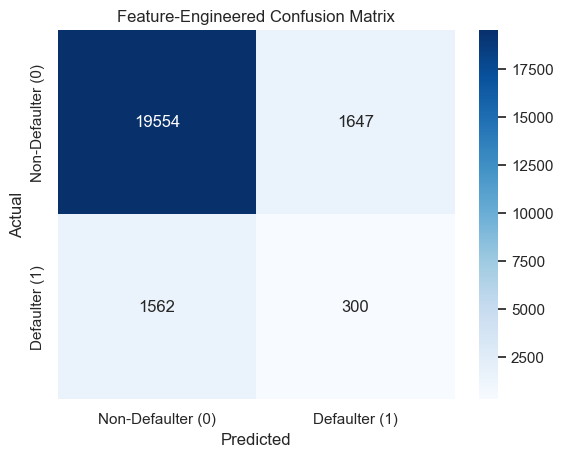

In [9]:
# Define the XGBoost model (same as baseline for fair comparison, but scale_pos_weight might not be needed/optimal after SMOTE)
# After SMOTE, the classes are balanced, so scale_pos_weight is removed for the FE model trained on SMOTE'd data.

fe_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss', # Using logloss as eval_metric, auc is also common
    use_label_encoder=False, # Suppress warning
    random_state=42
    # scale_pos_weight is removed as SMOTE balances the training set
)

# Train the model on the feature-engineered and resampled training data
print("Training feature-engineered model...")
fe_model.fit(X_train_fe_resampled, y_train_fe_resampled)
print("Feature-engineered model training complete.")

# Make predictions on the (original, not resampled) feature-engineered validation set
# X_val_fe_processed was prepared in the previous cell
y_pred_val_fe = fe_model.predict(X_val_fe_processed)
y_pred_proba_val_fe = fe_model.predict_proba(X_val_fe_processed)[:, 1]

# Evaluate the feature-engineered model
print("\nFeature-Engineered Model Performance on Validation Set:")
accuracy_fe = accuracy_score(y_val, y_pred_val_fe) # y_val is original validation target
roc_auc_fe = roc_auc_score(y_val, y_pred_proba_val_fe)
precision_fe_class1 = precision_score(y_val, y_pred_val_fe, pos_label=1)
recall_fe_class1 = recall_score(y_val, y_pred_val_fe, pos_label=1)
f1_fe_class1 = f1_score(y_val, y_pred_val_fe, pos_label=1)

print(f"Accuracy: {accuracy_fe:.4f}")
print(f"ROC AUC Score: {roc_auc_fe:.4f}")
print(f"Precision (Defaulter - 1): {precision_fe_class1:.4f}")
print(f"Recall (Defaulter - 1): {recall_fe_class1:.4f}")
print(f"F1-score (Defaulter - 1): {f1_fe_class1:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_val_fe, target_names=['Non-Defaulter (0)', 'Defaulter (1)']))

print("\nConfusion Matrix:")
cm_fe = confusion_matrix(y_val, y_pred_val_fe)
sns.heatmap(cm_fe, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Defaulter (0)', 'Defaulter (1)'], yticklabels=['Non-Defaulter (0)', 'Defaulter (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Feature-Engineered Confusion Matrix')
plt.show()

## 4. Comparison and Conclusion

### Performance Comparison (Validation Set):

| Metric                        | Baseline Model | Feature Engineered Model | Change          |
|-------------------------------|----------------|--------------------------|-----------------|
| Accuracy                      | 0.6839         | 0.8609                   | +0.1770         |
| ROC AUC Score                 | 0.6391         | 0.6173                   | -0.0218         |
| Precision (Defaulter - 1)     | 0.1300         | 0.1541                   | +0.0241         |
| Recall (Defaulter - 1)        | 0.5000         | 0.1611                   | -0.3389         |
| F1-score (Defaulter - 1)      | 0.2000         | 0.1575                   | -0.0425         |

*(The "Change" column is calculated as (Feature Engineered Model Score - Baseline Model Score).)*

### Discussion:

*(Analyze the table above and the classification reports/confusion matrices.
- **Overall Performance:** The feature engineering techniques, including SMOTE, led to a significant increase in overall **Accuracy** (from 0.6839 to 0.8609). However, this appears to be driven by better performance on the majority class (Non-Defaulters), as indicated by the classification report for the FE model.
- **ROC AUC Score:** The **ROC AUC Score** slightly decreased from 0.6391 to 0.6173. This suggests that the feature-engineered model's ability to distinguish between the positive and negative classes across various thresholds has marginally worsened.
- **Minority Class (Defaulter - 1) Performance:**
    - **Precision (Defaulter - 1)** saw a small improvement from 0.1300 to 0.1541. This means that when the FE model predicts a default, it's slightly more likely to be correct than the baseline.
    - **Recall (Defaulter - 1)** experienced a substantial decrease from 0.5000 to 0.1611. This is a critical metric for this problem, as it indicates the model is now identifying only about 16% of actual defaulters, compared to 50% by the baseline. This is a significant negative impact.
    - **F1-score (Defaulter - 1)** also decreased from 0.2000 to 0.1575, reflecting the poor recall despite a slight precision gain.

- **Impact of Feature Engineering Techniques:**
    - **SMOTE:** While SMOTE was intended to improve recall for the minority class by balancing the training set, it seems to have had the opposite effect on the validation set's recall for defaulters. This could happen if the synthetic samples generated by SMOTE were not truly representative of the minority class or led the model to learn overly specific patterns that didn't generalize well to unseen data. It might have also made the decision boundary more complex in a way that hurt recall on real minority samples. The baseline model used `scale_pos_weight`, which directly influenced the XGBoost algorithm's loss function to penalize misclassifying the minority class more heavily. Removing this when using SMOTE (which is standard practice, as SMOTE handles the balancing at the data level) might have contributed to the recall drop if SMOTE's synthetic samples weren't as effective.
    - **Domain-Specific Features & Binning:** The newly created financial ratios and binned age were intended to provide stronger signals. However, the overall drop in ROC AUC and, crucially, recall for the defaulter class suggests these features, in combination with SMOTE and the current model parameters, did not lead to a better model for identifying defaulters.
        - It's possible the new features introduced noise or were not as predictive as hypothesized.
        - The binning strategy for age might have been suboptimal, losing some important granular information.
        - The interaction between these new features and the synthetic samples from SMOTE might have been detrimental.

- **Why Performance Did Not Improve (Specifically for Minority Class):**
    - The primary goal in credit default is often to maximize the identification of true defaulters (high recall for class 1) while maintaining reasonable precision. The feature engineering strategy employed here failed in this regard.
    - The baseline model's `scale_pos_weight` might have been a more effective, albeit simpler, way to handle imbalance for this specific dataset and XGBoost configuration than the SMOTE + new features combination tried here.
    - The synthetic samples from SMOTE might have been created in regions of the feature space that are "too easy" or not truly representative of the hard-to-classify minority instances, leading the model to become overconfident in non-default predictions or less sensitive to true default signals in the validation data.
    - The chosen features for engineering, or the way they were engineered, might not have captured the underlying risk factors effectively or could have even obscured them. For instance, financial ratios can be sensitive to outliers or missing values in their components if not handled carefully during their creation.

- **Overall Conclusions:**
    The applied feature engineering techniques, including SMOTE, significantly improved overall accuracy but detrimentally impacted the model's ability to identify defaulters (recall for class 1) and its general discriminative power (ROC AUC). This highlights that feature engineering is an iterative process and not all techniques will universally improve performance, especially in imbalanced classification scenarios. The interaction between data-level balancing (SMOTE) and algorithm-level balancing (like `scale_pos_weight`) needs careful consideration. In this case, the baseline's direct cost-sensitive learning via `scale_pos_weight` was more effective for minority class recall.